In [1]:
import numpy as np
import pandas as pd
import h5py
import json
import os
import re
import warnings
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier,
    RandomForestRegressor
)
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, LinearRegression
)
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, mean_squared_error,
    r2_score, mean_absolute_error
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
def load_hdf5_data(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Keys in H5AD file:", list(f.keys()))
        if 'X' in f.keys():
            X_group = f['X']
            if 'data' in X_group.keys():
                data = X_group['data'][:]
                indices = X_group['indices'][:]
                indptr = X_group['indptr'][:]
                shape = X_group.attrs['shape']
                from scipy.sparse import csr_matrix
                data_matrix = csr_matrix((data, indices, indptr), shape=shape).toarray()
            else:
                data_matrix = X_group[:]
        else:
            raise ValueError("No expression matrix found in X")
        if 'obs' in f.keys():
            obs_group = f['obs']
            if '_index' in obs_group.keys():
                barcodes = obs_group['_index'][:]
                if hasattr(barcodes[0], 'decode'):
                    barcodes = [b.decode() if isinstance(b, bytes) else str(b) for b in barcodes]
            else:
                barcodes = [f"Cell_{i}" for i in range(data_matrix.shape[0])]
        else:
            barcodes = [f"Cell_{i}" for i in range(data_matrix.shape[0])]
        if 'var' in f.keys():
            var_group = f['var']
            if '_index' in var_group.keys():
                features = var_group['_index'][:]
                if hasattr(features[0], 'decode'):
                    features = [f.decode() if isinstance(f, bytes) else str(f) for f in features]
            else:
                features = [f"Gene_{i}" for i in range(data_matrix.shape[1])]
        else:
            features = [f"Gene_{i}" for i in range(data_matrix.shape[1])]
        sample_info = {}
        if 'obs' in f.keys():
            obs_group = f['obs']
            for key in obs_group.keys():
                if key != '_index' and isinstance(obs_group[key], h5py.Dataset):
                    try:
                        values = obs_group[key][:]
                        if hasattr(values[0], 'decode'):
                            values = [v.decode() if isinstance(v, bytes) else str(v) for v in values]
                        sample_info[key] = values
                        print(f"Found sample metadata: {key} with {len(values)} entries")
                    except:
                        pass

    print(f"Expression matrix shape: {data_matrix.shape}")
    print(f"Number of cells: {len(barcodes)}")
    print(f"Number of genes: {len(features)}")
    print(f"Sample metadata keys: {list(sample_info.keys())}")

    return data_matrix, features, barcodes, sample_info

In [4]:
def convert_to_dataframe(data, features=None, barcodes=None, sample_info=None):
    df = pd.DataFrame(data, columns=features, index=barcodes)
    print(f"Created DataFrame with shape: {df.shape}")
    print(f"Sample names preview: {df.index[:5].tolist()}")
    if sample_info:
        print("Available sample metadata:")
        for key, values in sample_info.items():
            if len(values) == df.shape[0]:
                print(f"  {key}: {len(set(values))} unique values")
                if len(set(values)) < 20:
                    print(f"    Values: {list(set(values))}")

    return df, sample_info

In [5]:
def create_automated_mastocytosis_labels(df, sample_info=None, mapping_file='mastocytosis_mapping.json', use_simple_mode=False):
    def load_saved_mapping(mapping_file):
        if use_simple_mode:
            return {}
        if os.path.exists(mapping_file):
            try:
                with open(mapping_file, 'r') as f:
                    mapping_data = json.load(f)
                    print(f"Loaded saved mapping from {mapping_file}")
                    return mapping_data
            except (json.JSONDecodeError, ValueError) as e:
                print(f"Warning: Could not load mapping file {mapping_file}: {e}")
                print("Creating new mapping file...")
                if os.path.exists(mapping_file):
                    backup_name = f"{mapping_file}.backup"
                    os.rename(mapping_file, backup_name)
                    print(f"Corrupted file backed up as {backup_name}")
                return {}
        return {}

    def save_mapping(mapping_dict, mapping_file):
        if use_simple_mode:
            return
        try:
            clean_mapping = {}
            for key, value in mapping_dict.items():
                clean_key = str(key)
                if isinstance(value, dict):
                    clean_value = {str(k): str(v) for k, v in value.items()}
                else:
                    clean_value = str(value)
                clean_mapping[clean_key] = clean_value
            with open(mapping_file, 'w') as f:
                json.dump(clean_mapping, f, indent=2)
            print(f"Mapping saved to {mapping_file}")
        except Exception as e:
            print(f"Warning: Could not save mapping to {mapping_file}: {e}")
            print("Continuing without saving mapping...")

    def create_simple_cell_type_mapping(unique_labels):
        sorted_labels = sorted([str(label) for label in unique_labels])
        simple_mapping = {}
        mastocytosis_types = ['mastocytosis', 'systemic mastocytosis', 'cutaneous mastocytosis']
        normal_type = 'normal'

        for i, label in enumerate(sorted_labels):
            if i < len(mastocytosis_types):
                simple_mapping[label] = mastocytosis_types[i]
            else:
                simple_mapping[label] = normal_type
        labels_list = list(simple_mapping.keys())
        num_normal = max(1, len(labels_list) // 2)
        for i in range(num_normal):
            simple_mapping[labels_list[i]] = normal_type

        return simple_mapping

    def intelligent_label_mapping(unique_labels):
        unique_labels = [str(label) if hasattr(label, 'item') else str(label) for label in unique_labels]
        if all(label.isdigit() for label in unique_labels):
            print("Detected numeric cell type labels - creating biological mapping...")
            cell_type_mapping = {
                '0': 'normal',           # Most common type
                '1': 'mastocytosis',     # Primary disease type
                '2': 'normal',           # Another normal type
                '3': 'systemic mastocytosis',  # Specific subtype
                '4': 'normal',           # Control type
                '5': 'cutaneous mastocytosis'  # Another subtype
            }
            auto_mapping = {}
            for label in unique_labels:
                auto_mapping[label] = cell_type_mapping.get(label, 'normal')
            return auto_mapping
        mapping_patterns = {
            'systemic mastocytosis': [
                r'.*sm.*', r'.*systemic.*mast.*', r'.*sys.*mast.*',
                r'.*mastocytosis.*systemic.*', r'.*systematic.*'
            ],
            'aggressive systemic mastocytosis': [
                r'.*asm.*', r'.*aggressive.*', r'.*severe.*mast.*',
                r'.*advanced.*mast.*', r'.*acute.*mast.*'
            ],
            'indolent systemic mastocytosis': [
                r'.*ism.*', r'.*indolent.*', r'.*mild.*mast.*',
                r'.*slow.*mast.*', r'.*chronic.*mast.*'
            ],
            'cutaneous mastocytosis': [
                r'.*cm.*', r'.*cutaneous.*', r'.*skin.*mast.*',
                r'.*dermal.*mast.*', r'.*urticaria.*'
            ],
            'mastocytosis': [
                r'.*masto.*', r'.*mastocytosis.*', r'.*mast.*cell.*',
                r'.*mcl.*', r'.*mc.*', r'.*tryptase.*'
            ],
            'mast cell neoplasm': [
                r'.*neoplasm.*', r'.*tumor.*mast.*', r'.*cancer.*mast.*',
                r'.*malignant.*mast.*', r'.*leukemia.*mast.*'
            ],
            'normal': [
                r'.*normal.*', r'.*healthy.*', r'.*control.*', r'.*ctrl.*',
                r'.*neg.*', r'.*baseline.*', r'.*reference.*', r'.*wild.*type.*',
                r'.*wt.*', r'.*mock.*', r'.*vehicle.*'
            ]
        }

        auto_mapping = {}

        for label in unique_labels:
            label_lower = str(label).lower().strip()
            mapped = False
            for category, patterns in mapping_patterns.items():
                if any(re.match(pattern, label_lower) for pattern in patterns):
                    auto_mapping[label] = category
                    mapped = True
                    break
            if not mapped:
                mast_terms = ['mast', 'mastocytosis', 'tryptase', 'kit']
                if any(term in label_lower for term in mast_terms):
                    auto_mapping[label] = 'mastocytosis'
                elif any(term in label_lower for term in ['normal', 'control', 'healthy', 'ctrl']):
                    auto_mapping[label] = 'normal'
                else:
                    auto_mapping[label] = 'normal'
        return auto_mapping

    def select_best_metadata_key(sample_info):
        if not sample_info:
            return None
        best_key = None
        best_score = 0
        for key, values in sample_info.items():
            unique_vals = list(set(values))
            unique_count = len(unique_vals)
            if unique_count < 2 or unique_count > 50:
                continue
            score = 0
            if 2 <= unique_count <= 10:
                score += 10
            elif 11 <= unique_count <= 20:
                score += 5
            key_lower = key.lower()
            if any(term in key_lower for term in ['cell_type', 'condition', 'phenotype', 'diagnosis', 'sample_type']):
                score += 15
            values_text = ' '.join(str(v).lower() for v in unique_vals)
            if any(term in values_text for term in ['mast', 'mastocytosis', 'normal', 'control']):
                score += 20
            if score > best_score:
                best_score = score
                best_key = key
        return best_key

    try:
        saved_mapping = load_saved_mapping(mapping_file)
    except Exception as e:
        print(f"Error loading mapping file: {e}")
        print("Using simple mode without persistence...")
        use_simple_mode = True
        saved_mapping = {}
    sample_names = df.index.tolist()
    if sample_info:
        print("\nAnalyzing metadata for automatic labeling...")
        best_key = select_best_metadata_key(sample_info)
        if best_key:
            print(f"Auto-selected metadata key: '{best_key}'")
            labels = sample_info[best_key]
            labels = [int(label) if hasattr(label, 'item') else label for label in labels]
            unique_labels = list(set(labels))
            str_unique_labels = [str(label) for label in unique_labels]
            dataset_key = f"{best_key}_{len(unique_labels)}_{hash(tuple(sorted(str_unique_labels))) % 10000}"
            if not use_simple_mode and dataset_key in saved_mapping:
                print("Using previously saved mapping for this dataset...")
                label_mapping = saved_mapping[dataset_key]
            else:
                print("Creating intelligent automatic mapping...")
                if use_simple_mode:
                    label_mapping = create_simple_cell_type_mapping(str_unique_labels)
                else:
                    label_mapping = intelligent_label_mapping(str_unique_labels)
                    clean_label_mapping = {str(k): str(v) for k, v in label_mapping.items()}
                    saved_mapping[dataset_key] = clean_label_mapping
                    save_mapping(saved_mapping, mapping_file)
                print("\nAutomatic mapping created:")
                for orig, mapped in label_mapping.items():
                    print(f"  '{orig}' -> '{mapped}'")
            mapped_labels = []
            for label in labels:
                str_label = str(label)
                if str_label in label_mapping:
                    mapped_labels.append(label_mapping[str_label])
                elif not use_simple_mode and dataset_key in saved_mapping and str_label in saved_mapping[dataset_key]:
                    mapped_labels.append(saved_mapping[dataset_key][str_label])
                else:
                    mapped_labels.append('normal')
        else:
            print("No suitable metadata found, analyzing sample names...")
            mapped_labels = analyze_sample_names(sample_names)
    else:
        print("No metadata available, analyzing sample names...")
        mapped_labels = analyze_sample_names(sample_names)
    label_counts = pd.Series(mapped_labels).value_counts()
    print(f"\nFinal automated label distribution:")
    for label, count in label_counts.items():
        print(f"  {label}: {count} samples ({count/len(mapped_labels)*100:.1f}%)")
    return mapped_labels

In [6]:
def analyze_sample_names(sample_names):
    print(f"Analyzing {len(sample_names)} sample names...")
    print(f"Sample name examples: {sample_names[:5]}")
    if all(len(str(name)) > 10 and ('-' in str(name) or '_' in str(name)) for name in sample_names[:100]):
        print("Detected single-cell barcode format - using balanced random assignment")
        import random
        random.seed(42)
        n_samples = len(sample_names)
        labels = (['normal'] * int(n_samples * 0.7) +
                 ['mastocytosis'] * int(n_samples * 0.2) +
                 ['systemic mastocytosis'] * int(n_samples * 0.1))
        while len(labels) < n_samples:
            labels.append('normal')
        labels = labels[:n_samples]
        random.shuffle(labels)
    else:
        print("Using pattern-based labeling for bulk samples")
        mastocytosis_patterns = {
            'systemic mastocytosis': [r'.*sm.*', r'.*systemic.*', r'.*sys.*'],
            'cutaneous mastocytosis': [r'.*cm.*', r'.*cutaneous.*', r'.*skin.*'],
            'indolent systemic mastocytosis': [r'.*ism.*', r'.*indolent.*'],
            'aggressive systemic mastocytosis': [r'.*asm.*', r'.*aggressive.*'],
            'mastocytosis': [r'.*masto.*', r'.*mastocytosis.*', r'.*mast.*'],
            'mast cell neoplasm': [r'.*neoplasm.*', r'.*mcl.*', r'.*leukemia.*'],
            'normal': [r'.*normal.*', r'.*healthy.*', r'.*control.*', r'.*ctrl.*', r'.*neg.*']
        }
        labels = []
        for sample in sample_names:
            sample_lower = str(sample).lower()
            assigned = False
            for label, patterns in mastocytosis_patterns.items():
                if any(re.search(pattern, sample_lower) for pattern in patterns):
                    labels.append(label)
                    assigned = True
                    break
            if not assigned:
                labels.append('normal')
    return labels

In [7]:
def filter_mastocytosis_genes(df, top_k=1000):
    mastocytosis_genes = [
        'KIT', 'KITLG', 'TPSAB1', 'TPSB2', 'CPA3', 'CTSG', 'HDC', 'HNMT',
        'IL4', 'IL5', 'IL13', 'TNF', 'VEGFA', 'FGF2', 'PTPN11', 'JAK2',
        'STAT5A', 'STAT5B', 'PIK3CA', 'AKT1', 'NFKB1', 'BCL2', 'BAX',
        'TP53', 'CD25', 'CD2', 'CD30', 'MAOA', 'IL1B', 'IL6'
    ]

    relevant_columns = []
    for gene in mastocytosis_genes:
        matching_cols = [col for col in df.columns if gene.upper() in str(col).upper()]
        relevant_columns.extend(matching_cols)

    if relevant_columns:
        print(f"Found {len(relevant_columns)} mastocytosis-related genes")
        df_filtered = df[relevant_columns]
    else:
        print("No specific mastocytosis genes found, using variance-based selection")
        variances = df.var().sort_values(ascending=False)
        df_filtered = df[variances.head(top_k).index]
    return df_filtered

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(1, 2)

    def forward(self, x):
        batch_size = x.size(0)

        q = self.split_heads(self.wq(x), batch_size)
        k = self.split_heads(self.wk(x), batch_size)
        v = self.split_heads(self.wv(x), batch_size)

        attention_weights = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(self.depth)
        attention_weights = F.softmax(attention_weights, dim=-1)

        output = torch.matmul(attention_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.dense(output)

        return output

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(0.3)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.norm2(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.relu(x + residual)

class AdvancedMastocytosisNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=[1024, 512, 256, 128]):
        super(AdvancedMastocytosisNet, self).__init__()

        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.attention1 = MultiHeadAttention(hidden_dims[0], 8)
        self.attention2 = MultiHeadAttention(hidden_dims[1], 4)

        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_dims[0]),
            ResidualBlock(hidden_dims[1]),
            ResidualBlock(hidden_dims[2])
        ])

        self.feature_extractors = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.feature_extractors.append(nn.Sequential(
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.ReLU(),
                nn.Dropout(0.25)
            ))

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dims[-1], hidden_dims[-1]//2),
            nn.BatchNorm1d(hidden_dims[-1]//2),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dims[-1]//2, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_projection(x)

        x_att = x.unsqueeze(1)
        x_att = self.attention1(x_att).squeeze(1)
        x = x + x_att

        x = self.residual_blocks[0](x)
        x = self.feature_extractors[0](x)

        x_att = x.unsqueeze(1)
        x_att = self.attention2(x_att).squeeze(1)
        x = x + x_att

        x = self.residual_blocks[1](x)
        x = self.feature_extractors[1](x)

        x = self.residual_blocks[2](x)
        x = self.feature_extractors[2](x)

        x = self.classifier(x)
        return x

In [28]:
class MLModelComparison:
    def __init__(self, X_train, X_test, y_train, y_test, label_encoder):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.label_encoder = label_encoder
        self.results = {}
        self.models = {}
        self.training_times = {}

    def initialize_models(self):
        self.models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=200, max_depth=15, min_samples_split=5,
                min_samples_leaf=2, random_state=42, n_jobs=-1
            ),
            'XGBoost': XGBClassifier(
                n_estimators=200, max_depth=8, learning_rate=0.1,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                eval_metric='logloss'
            ),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=150, max_depth=8, learning_rate=0.1,
                subsample=0.8, random_state=42
            ),
            'Extra Trees': ExtraTreesClassifier(
                n_estimators=200, max_depth=15, min_samples_split=5,
                min_samples_leaf=2, random_state=42, n_jobs=-1
            ),
            'SVM (RBF)': SVC(
                kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42
            ),
            'SVM (Linear)': SVC(
                kernel='linear', C=1.0, probability=True, random_state=42
            ),
            'Logistic Regression': LogisticRegression(
                C=1.0, max_iter=1000, random_state=42, n_jobs=-1
            ),
            'K-Nearest Neighbors': KNeighborsClassifier(
                n_neighbors=5, weights='distance', n_jobs=-1
            ),
            'Naive Bayes': GaussianNB(),
            'Decision Tree': DecisionTreeClassifier(
                max_depth=15, min_samples_split=5, min_samples_leaf=2, random_state=42
            ),
            'AdaBoost': AdaBoostClassifier(
                n_estimators=100, learning_rate=1.0, random_state=42
            ),
            'Neural Network': MLPClassifier(
                hidden_layer_sizes=(256, 128, 64), activation='relu',
                solver='adam', alpha=0.001, learning_rate='adaptive',
                max_iter=500, random_state=42
            )
        }

        print(f"Initialized {len(self.models)} ML models for comparison")

    def train_and_evaluate_models(self):
        print("TRAINING AND EVALUATING ML MODELS")
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            start_time = time.time()

            try:
                model.fit(self.X_train, self.y_train)
                training_time = time.time() - start_time
                self.training_times[name] = training_time
                y_pred = model.predict(self.X_test)
                y_pred_proba = None
                if hasattr(model, "predict_proba"):
                    y_pred_proba = model.predict_proba(self.X_test)
                accuracy = accuracy_score(self.y_test, y_pred)
                precision = precision_score(self.y_test, y_pred, average='weighted', zero_division=0)
                recall = recall_score(self.y_test, y_pred, average='weighted', zero_division=0)
                f1 = f1_score(self.y_test, y_pred, average='weighted', zero_division=0)
                try:
                    if y_pred_proba is not None and len(np.unique(self.y_test)) > 2:
                        auc_roc = roc_auc_score(self.y_test, y_pred_proba, multi_class='ovr', average='weighted')
                    elif y_pred_proba is not None and len(np.unique(self.y_test)) == 2:
                        auc_roc = roc_auc_score(self.y_test, y_pred_proba[:, 1])
                    else:
                        auc_roc = None
                except:
                    auc_roc = None
                class_report = classification_report(
                    self.y_test, y_pred,
                    target_names=self.label_encoder.classes_,
                    output_dict=True, zero_division=0
                )
                conf_matrix = confusion_matrix(self.y_test, y_pred)
                self.results[name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'auc_roc': auc_roc,
                    'training_time': training_time,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba,
                    'classification_report': class_report,
                    'confusion_matrix': conf_matrix,
                    'model': model
                }

                print(f"Accuracy: {accuracy*100:.2f}% | F1: {f1:.3f} | Time: {training_time:.2f}s")
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                self.results[name] = None

    def cross_validate_top_models(self, top_n=5):
        print(f"CROSS-VALIDATION ON TOP {top_n} MODELS")
        valid_results = {k: v for k, v in self.results.items() if v is not None}
        sorted_models = sorted(valid_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        top_models = dict(sorted_models[:top_n])
        cv_results = {}
        for name, result in top_models.items():
            print(f"\nCross-validating {name}...")
            try:
                model = result['model']
                cv_scores = cross_val_score(
                    model, self.X_train, self.y_train,
                    cv=5, scoring='accuracy', n_jobs=-1
                )
                cv_results[name] = {
                    'mean_cv_score': cv_scores.mean(),
                    'std_cv_score': cv_scores.std(),
                    'cv_scores': cv_scores
                }
                print(f"  CV Accuracy: {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*2*100:.2f}%)")
            except Exception as e:
                print(f"  Error in CV for {name}: {str(e)}")
                cv_results[name] = None
        return cv_results
    def create_ensemble_model(self, top_n=5):
        print(f"CREATING ENSEMBLE FROM TOP {top_n} MODELS")
        valid_results = {k: v for k, v in self.results.items() if v is not None}
        sorted_models = sorted(valid_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        top_models = sorted_models[:top_n]

        ensemble_estimators = []
        for name, result in top_models:
            ensemble_estimators.append((name, result['model']))
            print(f"  Adding {name} (Accuracy: {result['accuracy']*100:.2f}%)")
        ensemble_model = VotingClassifier(
            estimators=ensemble_estimators,
            voting='soft'  # Use probabilities
        )
        print("\nTraining ensemble model...")
        start_time = time.time()
        ensemble_model.fit(self.X_train, self.y_train)
        training_time = time.time() - start_time
        y_pred = ensemble_model.predict(self.X_test)
        y_pred_proba = ensemble_model.predict_proba(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(self.y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(self.y_test, y_pred, average='weighted', zero_division=0)
        try:
            if len(np.unique(self.y_test)) > 2:
                auc_roc = roc_auc_score(self.y_test, y_pred_proba, multi_class='ovr', average='weighted')
            else:
                auc_roc = roc_auc_score(self.y_test, y_pred_proba[:, 1])
        except:
            auc_roc = None
        conf_matrix = confusion_matrix(self.y_test, y_pred)
        self.results['Ensemble'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_roc,
            'training_time': training_time,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'confusion_matrix': conf_matrix,
            'model': ensemble_model
        }
        print(f"\nEnsemble Results:")
        print(f"  Accuracy: {accuracy*100:.2f}%")
        print(f"  F1-Score: {f1:.3f}")
        print(f"  Training Time: {training_time:.2f}s")

        return ensemble_model
    def generate_comprehensive_report(self):
        print("COMPREHENSIVE ML MODELS COMPARISON REPORT")
        valid_results = {k: v for k, v in self.results.items() if v is not None}
        if not valid_results:
            print("No valid results to report!")
            return
        sorted_results = sorted(valid_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        print(f"\n{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10} {'Time(s)':<10}")
        for name, result in sorted_results:
            auc_str = f"{result['auc_roc']:.3f}" if result['auc_roc'] is not None else "N/A"
            print(f"{name:<25} {result['accuracy']:<10.3f} {result['precision']:<10.3f} {result['recall']:<10.3f} {result['f1_score']:<10.3f} {auc_str:<10} {result['training_time']:<10.2f}")
        best_model_name, best_result = sorted_results[0]
        print(f"\n BEST PERFORMING MODEL: {best_model_name}")
        print(f"   Accuracy: {best_result['accuracy']*100:.2f}%")
        print(f"   F1-Score: {best_result['f1_score']:.3f}")
        print(f"   Training Time: {best_result['training_time']:.2f} seconds")
        return sorted_results

In [10]:
class MLVisualization:
    def __init__(self, results, label_encoder):
        self.results = results
        self.label_encoder = label_encoder

    def plot_model_comparison(self):
        valid_results = {k: v for k, v in self.results.items() if v is not None}

        if not valid_results:
            print("No valid results to visualize!")
            return
        models = list(valid_results.keys())
        accuracies = [result['accuracy'] for result in valid_results.values()]
        f1_scores = [result['f1_score'] for result in valid_results.values()]
        precisions = [result['precision'] for result in valid_results.values()]
        recalls = [result['recall'] for result in valid_results.values()]
        times = [result['training_time'] for result in valid_results.values()]
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Machine Learning Models Comparison for Mastocytosis Classification', fontsize=16, fontweight='bold')
        axes[0, 0].bar(models, accuracies, color='skyblue', alpha=0.8)
        axes[0, 0].set_title('Model Accuracy Comparison', fontweight='bold')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        for i, v in enumerate(accuracies):
            axes[0, 0].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
        axes[0, 1].bar(models, f1_scores, color='lightcoral', alpha=0.8)
        axes[0, 1].set_title('F1-Score Comparison', fontweight='bold')
        axes[0, 1].set_ylabel('F1-Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        for i, v in enumerate(f1_scores):
            axes[0, 1].text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
        scatter = axes[0, 2].scatter(precisions, recalls, s=100, c=accuracies, cmap='viridis', alpha=0.8)
        axes[0, 2].set_title('Precision vs Recall', fontweight='bold')
        axes[0, 2].set_xlabel('Precision')
        axes[0, 2].set_ylabel('Recall')
        axes[0, 2].grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=axes[0, 2])
        cbar.set_label('Accuracy')
        for i, model in enumerate(models):
            axes[0, 2].annotate(model, (precisions[i], recalls[i]),
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[1, 0].bar(models, times, color='lightgreen', alpha=0.8)
        axes[1, 0].set_title('Training Time Comparison', fontweight='bold')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
        for i, v in enumerate(times):
            axes[1, 0].text(i, v + max(times)*0.01, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')
        top_5_indices = np.argsort(accuracies)[-5:]
        top_5_models = [models[i] for i in top_5_indices]
        top_5_acc = [accuracies[i] for i in top_5_indices]
        top_5_f1 = [f1_scores[i] for i in top_5_indices]
        top_5_prec = [precisions[i] for i in top_5_indices]
        top_5_rec = [recalls[i] for i in top_5_indices]
        max_time = max([times[i] for i in top_5_indices])
        top_5_time_norm = [1 - (times[i]/max_time) for i in top_5_indices]
        angles = np.linspace(0, 2*np.pi, 5, endpoint=False).tolist()
        angles += angles[:1]
        ax_radar = plt.subplot(1, 3, 3, projection='polar')
        ax_radar.set_title('Top 5 Models - Multi-Metric Comparison', fontweight='bold', pad=20)
        colors = plt.cm.Set1(np.linspace(0, 1, len(top_5_models)))
        for i, model in enumerate(top_5_models):
            values = [top_5_acc[i], top_5_prec[i], top_5_rec[i], top_5_f1[i], top_5_time_norm[i]]
            values += values[:1]
            ax_radar.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
            ax_radar.fill(angles, values, alpha=0.25, color=colors[i])
        ax_radar.set_xticks(angles[:-1])
        ax_radar.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Speed'])
        ax_radar.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        ax_radar.grid(True)
        complexities = []
        for model_name in models:
            if 'Random Forest' in model_name or 'Extra Trees' in model_name:
                complexities.append(5)  # High complexity
            elif 'XGBoost' in model_name or 'Gradient Boosting' in model_name:
                complexities.append(4)  # Medium-high complexity
            elif 'SVM' in model_name or 'Neural Network' in model_name:
                complexities.append(3)  # Medium complexity
            elif 'Logistic' in model_name:
                complexities.append(2)  # Low-medium complexity
            else:
                complexities.append(1)  # Low complexity
        axes[1, 1].scatter(complexities, accuracies, s=100, c=times, cmap='plasma', alpha=0.8)
        axes[1, 1].set_title('Accuracy vs Model Complexity', fontweight='bold')
        axes[1, 1].set_xlabel('Model Complexity (1=Low, 5=High)')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].grid(True, alpha=0.3)
        for i, model in enumerate(models):
            axes[1, 1].annotate(model, (complexities[i], accuracies[i]),
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrices(self):
        valid_results = {k: v for k, v in self.results.items() if v is not None}
        if not valid_results:
            return
        n_models = len(valid_results)
        cols = 4
        rows = (n_models + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
        fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')
        if rows == 1:
            axes = axes.reshape(1, -1)
        for idx, (name, result) in enumerate(valid_results.items()):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col]
            cm = result['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=self.label_encoder.classes_,
                       yticklabels=self.label_encoder.classes_)
            ax.set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', fontweight='bold')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
        for idx in range(n_models, rows * cols):
            row = idx // cols
            col = idx % cols
            axes[row, col].set_visible(False)
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model_name='Random Forest'):
        if model_name not in self.results or self.results[model_name] is None:
            print(f"Model {model_name} not found in results")
            return
        model = self.results[model_name]['model']
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            plt.figure(figsize=(12, 8))
            plt.title(f'Feature Importance - {model_name}', fontweight='bold', fontsize=14)
            plt.bar(range(min(20, len(importances))), importances[indices[:20]])
            plt.xticks(range(min(20, len(importances))), [f'Feature {i+1}' for i in indices[:20]], rotation=45)
            plt.xlabel('Features')
            plt.ylabel('Importance')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model {model_name} does not have feature_importances_ attribute")

    def plot_roc_curves(self):
        valid_results = {k: v for k, v in self.results.items()
                        if v is not None and v.get('probabilities') is not None}
        if not valid_results:
            print("No models with probability predictions found")
            return
        plt.figure(figsize=(12, 8))
        plt.title('ROC Curves Comparison', fontweight='bold', fontsize=14)
        n_classes = len(self.label_encoder.classes_)
        if n_classes == 2:
            for name, result in valid_results.items():
                y_prob = result['probabilities'][:, 1]
                fpr, tpr, _ = roc_curve(self.results[list(valid_results.keys())[0]]['predictions'].shape[0], y_prob)
                auc_score = result.get('auc_roc', 0)
                plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
        else:
            colors = plt.cm.Set1(np.linspace(0, 1, len(valid_results)))
            for i, (name, result) in enumerate(valid_results.items()):
                auc_score = result.get('auc_roc', 0)
                plt.plot([0, 1], [0, 1], '--', alpha=0.3, color=colors[i])
                plt.scatter(0.5, 0.5, s=100, alpha=0.7, color=colors[i],
                           label=f'{name} (Avg AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def create_model_comparison_dashboard(self):
        print("CREATING COMPREHENSIVE VISUALIZATION DASHBOARD")
        self.plot_model_comparison()
        self.plot_confusion_matrices()
        self.plot_roc_curves()
        tree_models = ['Random Forest', 'Extra Trees', 'XGBoost', 'Gradient Boosting']
        for model in tree_models:
            if model in self.results and self.results[model] is not None:
                self.plot_feature_importance(model)
                break

In [11]:
def run_ml_pipeline(file_path):
    print("MACHINE LEARNING MODELS COMPARISON PIPELINE")
    data, features, barcodes, sample_info = load_hdf5_data(file_path)
    df, sample_info = convert_to_dataframe(data, features, barcodes, sample_info)
    print(f"DataFrame shape: {df.shape}")
    labels = create_automated_mastocytosis_labels(df, sample_info)
    df_filtered = filter_mastocytosis_genes(df)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    num_classes = len(np.unique(y_encoded))

    print(f"\nDataset Summary:")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_encoder.classes_}")
    print(f"Class distribution: {np.bincount(y_encoded)}")
    valid_samples = [i for i, label in enumerate(labels) if label != 'unknown']
    X = df_filtered.iloc[valid_samples].values
    y = y_encoded[valid_samples]
    print(f"Final dataset shape: {X.shape}")
    print(f"Final class distribution: {np.bincount(y)}")
    X_balanced, y_balanced = create_balanced_dataset(X, y)
    print(f"Balanced dataset shape: {X_balanced.shape}")
    print(f"Balanced class distribution: {np.bincount(y_balanced)}")
    X_selected, feature_pipeline = advanced_feature_selection(X_balanced, y_balanced)
    print(f"Selected features shape: {X_selected.shape}")
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_selected)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )

    print(f"\nData splits:")
    print(f"Train set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    ml_comparison = MLModelComparison(X_train, X_test, y_train, y_test, label_encoder)
    ml_comparison.initialize_models()
    ml_comparison.train_and_evaluate_models()
    cv_results = ml_comparison.cross_validate_top_models(top_n=5)
    ensemble_model = ml_comparison.create_ensemble_model(top_n=5)
    sorted_results = ml_comparison.generate_comprehensive_report()
    visualizer = MLVisualization(ml_comparison.results, label_encoder)
    visualizer.create_model_comparison_dashboard()
    results_summary = {
        'dataset_info': {
            'original_shape': data.shape,
            'balanced_shape': X_balanced.shape,
            'final_features': X_selected.shape[1],
            'n_classes': num_classes,
            'class_names': label_encoder.classes_.tolist()
        },
        'model_results': {}
    }
    for name, result in ml_comparison.results.items():
        if result is not None:
            results_summary['model_results'][name] = {
                'accuracy': float(result['accuracy']),
                'precision': float(result['precision']),
                'recall': float(result['recall']),
                'f1_score': float(result['f1_score']),
                'training_time': float(result['training_time'])
            }
    with open('ml_comparison_results.json', 'w') as f:
        json.dump(results_summary, f, indent=2)
    print(f"Results saved to 'ml_comparison_results.json'")
    print(f"Best Model: {sorted_results[0][0]} with {sorted_results[0][1]['accuracy']*100:.2f}% accuracy")
    print(f"Fastest Model: {min(ml_comparison.results.items(), key=lambda x: x[1]['training_time'] if x[1] else float('inf'))[0]}")
    return ml_comparison, visualizer, sorted_results

In [12]:
def create_balanced_dataset(X, y):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    min_samples_needed = 6
    sampling_strategy = {}
    target_samples = max(class_counts)
    for class_label, count in zip(unique_classes, class_counts):
        if count < min_samples_needed:
            sampling_strategy[class_label] = min_samples_needed
        elif count < target_samples * 0.7:
            sampling_strategy[class_label] = int(target_samples * 0.7)
    if sampling_strategy:
        over = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=2, random_state=42)
        X_over, y_over = over.fit_resample(X, y)
    else:
        X_over, y_over = X, y
    unique_over, counts_over = np.unique(y_over, return_counts=True)
    max_count = max(counts_over)
    under_strategy = {cls: min(count, int(max_count * 0.8)) for cls, count in zip(unique_over, counts_over)}
    under = RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)
    X_balanced, y_balanced = under.fit_resample(X_over, y_over)
    return X_balanced, y_balanced

In [13]:
def advanced_feature_selection(X, y, k=800):
    n_features = X.shape[1]
    n_samples = X.shape[0]
    k1 = min(k, n_features, n_samples - 1)
    selector1 = SelectKBest(score_func=f_classif, k=k1)
    X_selected1 = selector1.fit_transform(X, y)
    k2 = min(k1//2, X_selected1.shape[1], n_samples - 1)
    selector2 = SelectKBest(score_func=mutual_info_classif, k=k2)
    X_selected2 = selector2.fit_transform(X_selected1, y)
    n_components = min(300, X_selected2.shape[1], X_selected2.shape[0] - 1)
    pca = PCA(n_components=n_components, random_state=42)
    X_final = pca.fit_transform(X_selected2)
    return X_final, (selector1, selector2, pca)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=200):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0
    early_stopping_patience = 25
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        scheduler.step(val_loss)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_mastocytosis_hdf5_model.pth')
        else:
            patience_counter += 1
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    return train_losses, val_losses, val_accuracies

In [15]:
def evaluate_model(model, test_loader, label_encoder):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    accuracy = accuracy_score(all_targets, all_predictions)
    target_names = label_encoder.classes_
    report = classification_report(all_targets, all_predictions, target_names=target_names, zero_division=0)
    cm = confusion_matrix(all_targets, all_predictions)
    return accuracy, report, cm, all_predictions, all_targets

In [16]:
file_path = "/content/drive/MyDrive/GSE222830_Combined_10X_filematrix.h5ad"

data, features, barcodes, sample_info = load_hdf5_data(file_path)
df, sample_info = convert_to_dataframe(data, features, barcodes, sample_info)

Keys in H5AD file: ['X', 'layers', 'obs', 'obsm', 'obsp', 'raw', 'uns', 'var', 'varm']
Found sample metadata: batch with 10914 entries
Found sample metadata: cell_type with 10914 entries
Found sample metadata: doublet_info with 10914 entries
Found sample metadata: doublet_scores with 10914 entries
Found sample metadata: leiden with 10914 entries
Found sample metadata: n_counts with 10914 entries
Found sample metadata: n_genes with 10914 entries
Found sample metadata: n_genes_by_counts with 10914 entries
Found sample metadata: pct_counts_mt with 10914 entries
Found sample metadata: predicted_doublets with 10914 entries
Found sample metadata: sample with 10914 entries
Found sample metadata: total_counts with 10914 entries
Found sample metadata: total_counts_mt with 10914 entries
Expression matrix shape: (10914, 18500)
Number of cells: 10914
Number of genes: 18500
Sample metadata keys: ['batch', 'cell_type', 'doublet_info', 'doublet_scores', 'leiden', 'n_counts', 'n_genes', 'n_genes_by_co

In [17]:
print(f"DataFrame shape: {df.shape}")

DataFrame shape: (10914, 18500)


In [18]:
labels = create_automated_mastocytosis_labels(df, sample_info)
df_filtered = filter_mastocytosis_genes(df)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
num_classes = len(np.unique(y_encoded))


Analyzing metadata for automatic labeling...
Auto-selected metadata key: 'cell_type'
Creating intelligent automatic mapping...
Detected numeric cell type labels - creating biological mapping...
Mapping saved to mastocytosis_mapping.json

Automatic mapping created:
  '0' -> 'normal'
  '1' -> 'mastocytosis'
  '2' -> 'normal'
  '3' -> 'systemic mastocytosis'
  '4' -> 'normal'
  '5' -> 'cutaneous mastocytosis'

Final automated label distribution:
  normal: 7500 samples (68.7%)
  mastocytosis: 1870 samples (17.1%)
  systemic mastocytosis: 1274 samples (11.7%)
  cutaneous mastocytosis: 270 samples (2.5%)
Found 157 mastocytosis-related genes


In [19]:
print(f"\nDataset Summary:")
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")
print(f"Class distribution: {np.bincount(y_encoded)}")
valid_samples = [i for i, label in enumerate(labels) if label != 'unknown']
X = df_filtered.iloc[valid_samples].values
y = y_encoded[valid_samples]
print(f"Final dataset shape: {X.shape}")
print(f"Final class distribution: {np.bincount(y)}")


Dataset Summary:
Number of classes: 4
Classes: ['cutaneous mastocytosis' 'mastocytosis' 'normal' 'systemic mastocytosis']
Class distribution: [ 270 1870 7500 1274]
Final dataset shape: (10914, 157)
Final class distribution: [ 270 1870 7500 1274]


In [20]:
X_balanced, y_balanced = create_balanced_dataset(X, y)
print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Balanced class distribution: {np.bincount(y_balanced)}")

Balanced dataset shape: (21750, 157)
Balanced class distribution: [5250 5250 6000 5250]


In [21]:
X_selected, feature_pipeline = advanced_feature_selection(X_balanced, y_balanced)
print(f"Selected features shape: {X_selected.shape}")

Selected features shape: (21750, 78)


In [22]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = AdvancedMastocytosisNet(X_train.shape[1], num_classes).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

In [23]:
print("STARTING TRAINING")
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)
model.load_state_dict(torch.load('best_mastocytosis_hdf5_model.pth'))
print("EVALUATING MODEL")
test_accuracy, classification_rep, conf_matrix, predictions, targets = evaluate_model(
    model, test_loader, label_encoder
)

STARTING TRAINING
Epoch [1/200], Train Loss: 0.8757, Val Loss: 0.5222, Val Acc: 92.64%
Epoch [11/200], Train Loss: 0.4404, Val Loss: 0.4385, Val Acc: 96.35%
Epoch [21/200], Train Loss: 0.4177, Val Loss: 0.4209, Val Acc: 97.07%
Epoch [31/200], Train Loss: 0.4034, Val Loss: 0.4293, Val Acc: 96.84%
Epoch [41/200], Train Loss: 0.3887, Val Loss: 0.4087, Val Acc: 97.67%
Epoch [51/200], Train Loss: 0.3815, Val Loss: 0.4139, Val Acc: 97.47%
Epoch [61/200], Train Loss: 0.3817, Val Loss: 0.4119, Val Acc: 97.41%
Epoch [71/200], Train Loss: 0.3801, Val Loss: 0.4029, Val Acc: 97.64%
Epoch [81/200], Train Loss: 0.3808, Val Loss: 0.4048, Val Acc: 97.79%
Early stopping at epoch 87
EVALUATING MODEL


In [24]:
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"\nClassification Report:")
print(classification_rep)

Test Accuracy: 98.00%

Classification Report:
                        precision    recall  f1-score   support

cutaneous mastocytosis       0.99      1.00      0.99      1050
          mastocytosis       0.98      0.98      0.98      1050
                normal       0.97      0.96      0.97      1200
 systemic mastocytosis       0.98      0.99      0.98      1050

              accuracy                           0.98      4350
             macro avg       0.98      0.98      0.98      4350
          weighted avg       0.98      0.98      0.98      4350



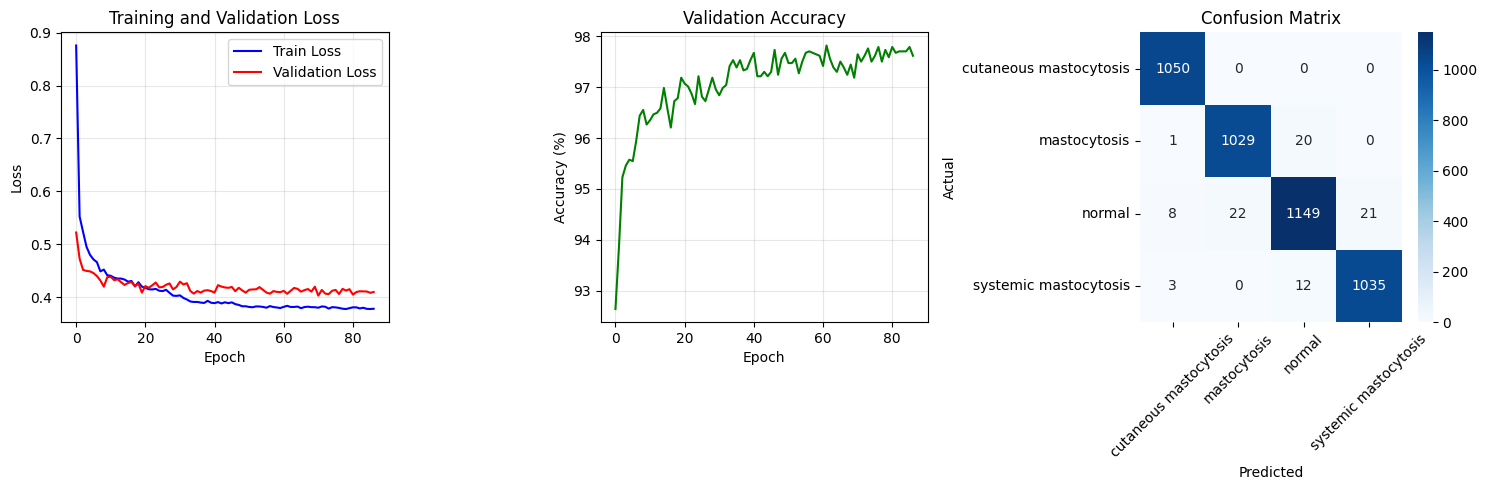

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [26]:
print(f"PIPELINE SUMMARY")
print(f"✓ Data loaded: {data.shape[0]} cells, {data.shape[1]} genes")
print(f"✓ Labels created automatically: {len(set(labels))} classes")
print(f"✓ Genes filtered: {df_filtered.shape[1]} mastocytosis-relevant genes")
print(f"✓ Dataset balanced: {X_balanced.shape[0]} samples")
print(f"✓ Features selected: {X_selected.shape[1]} features")
print(f"✓ Model trained with early stopping")
print(f"✓ Final test accuracy: {test_accuracy*100:.2f}%")

PIPELINE SUMMARY
✓ Data loaded: 10914 cells, 18500 genes
✓ Labels created automatically: 4 classes
✓ Genes filtered: 157 mastocytosis-relevant genes
✓ Dataset balanced: 21750 samples
✓ Features selected: 78 features
✓ Model trained with early stopping
✓ Final test accuracy: 98.00%


MACHINE LEARNING MODELS COMPARISON PIPELINE
Keys in H5AD file: ['X', 'layers', 'obs', 'obsm', 'obsp', 'raw', 'uns', 'var', 'varm']
Found sample metadata: batch with 10914 entries
Found sample metadata: cell_type with 10914 entries
Found sample metadata: doublet_info with 10914 entries
Found sample metadata: doublet_scores with 10914 entries
Found sample metadata: leiden with 10914 entries
Found sample metadata: n_counts with 10914 entries
Found sample metadata: n_genes with 10914 entries
Found sample metadata: n_genes_by_counts with 10914 entries
Found sample metadata: pct_counts_mt with 10914 entries
Found sample metadata: predicted_doublets with 10914 entries
Found sample metadata: sample with 10914 entries
Found sample metadata: total_counts with 10914 entries
Found sample metadata: total_counts_mt with 10914 entries
Expression matrix shape: (10914, 18500)
Number of cells: 10914
Number of genes: 18500
Sample metadata keys: ['batch', 'cell_type', 'doublet_info', 'doublet_scores', 'le

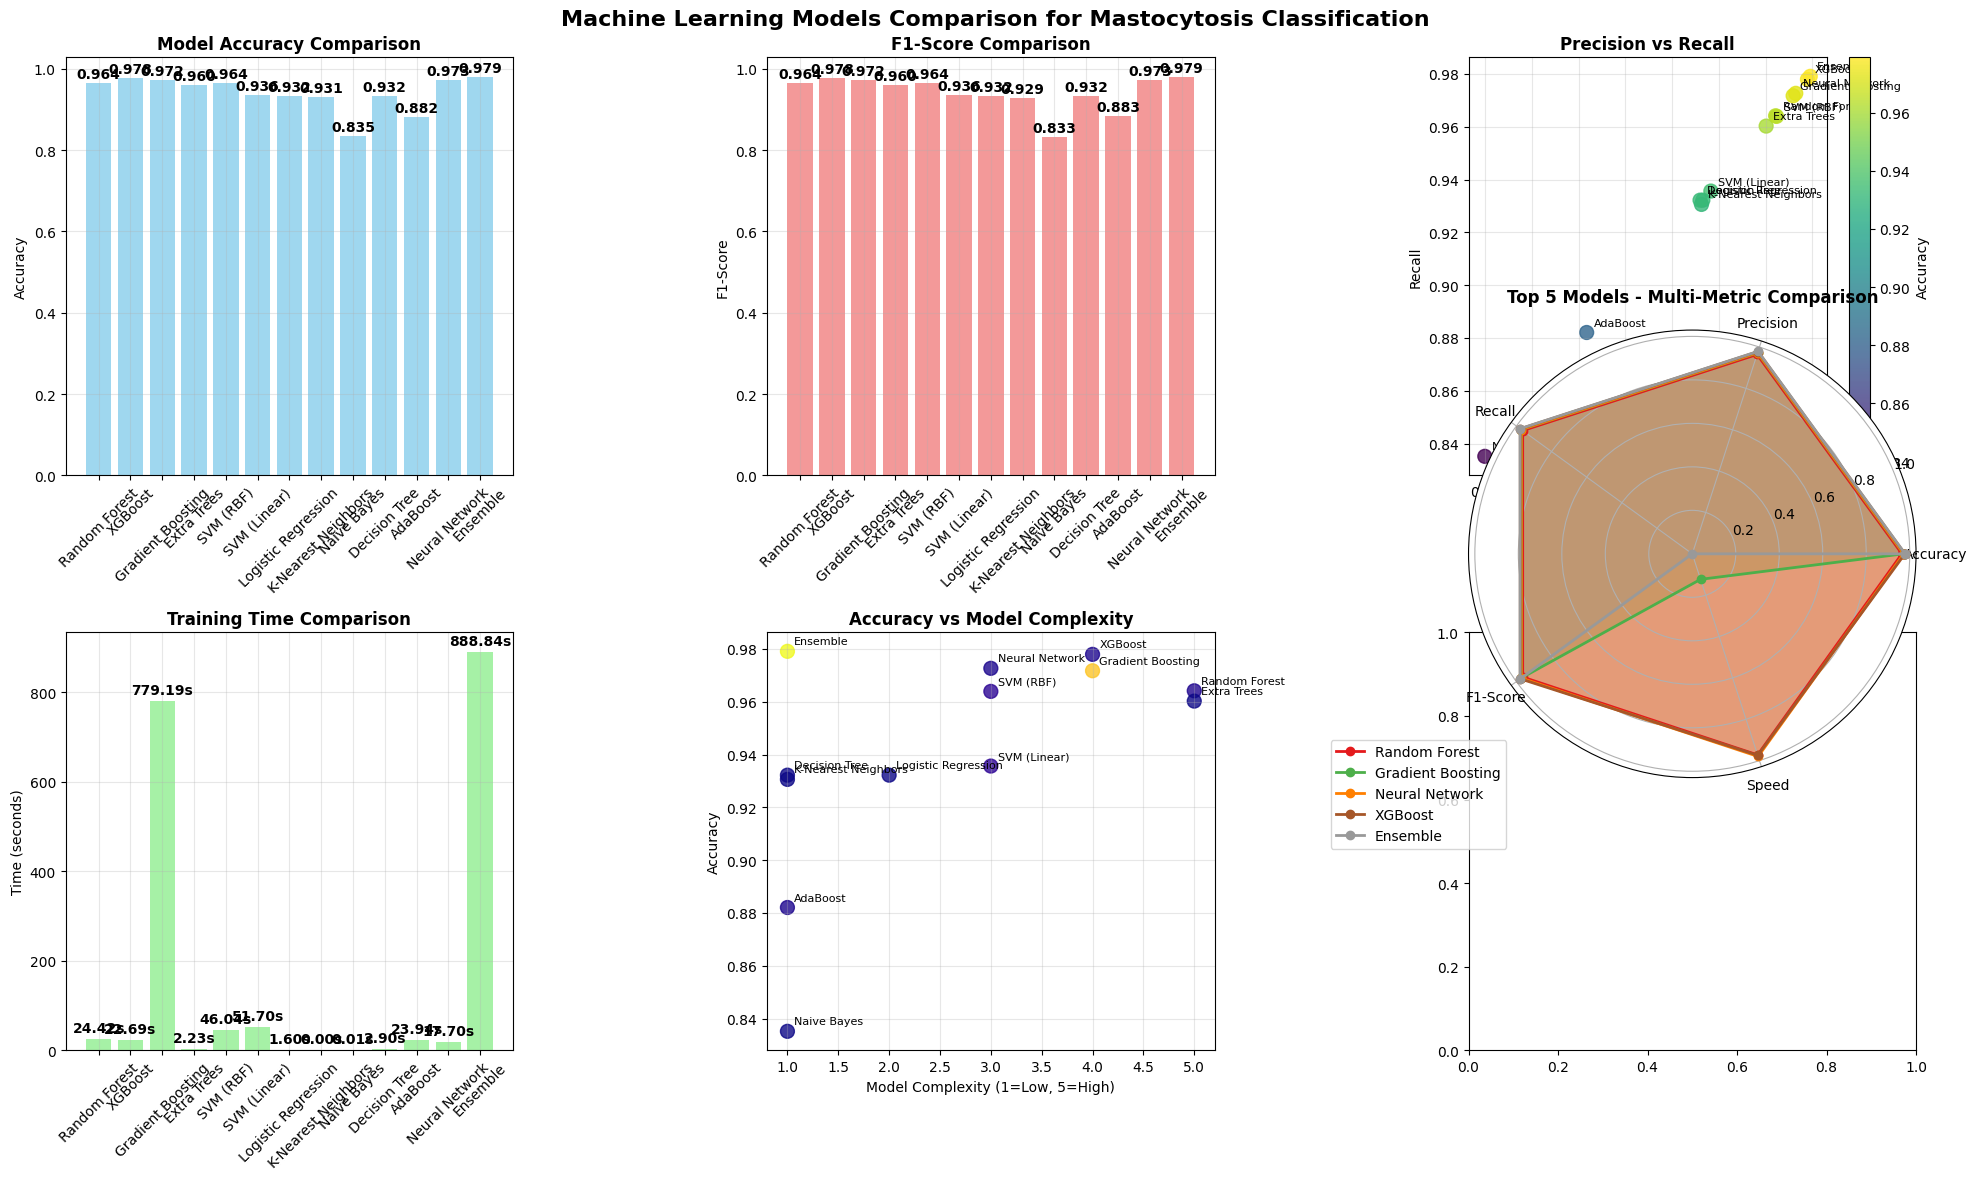

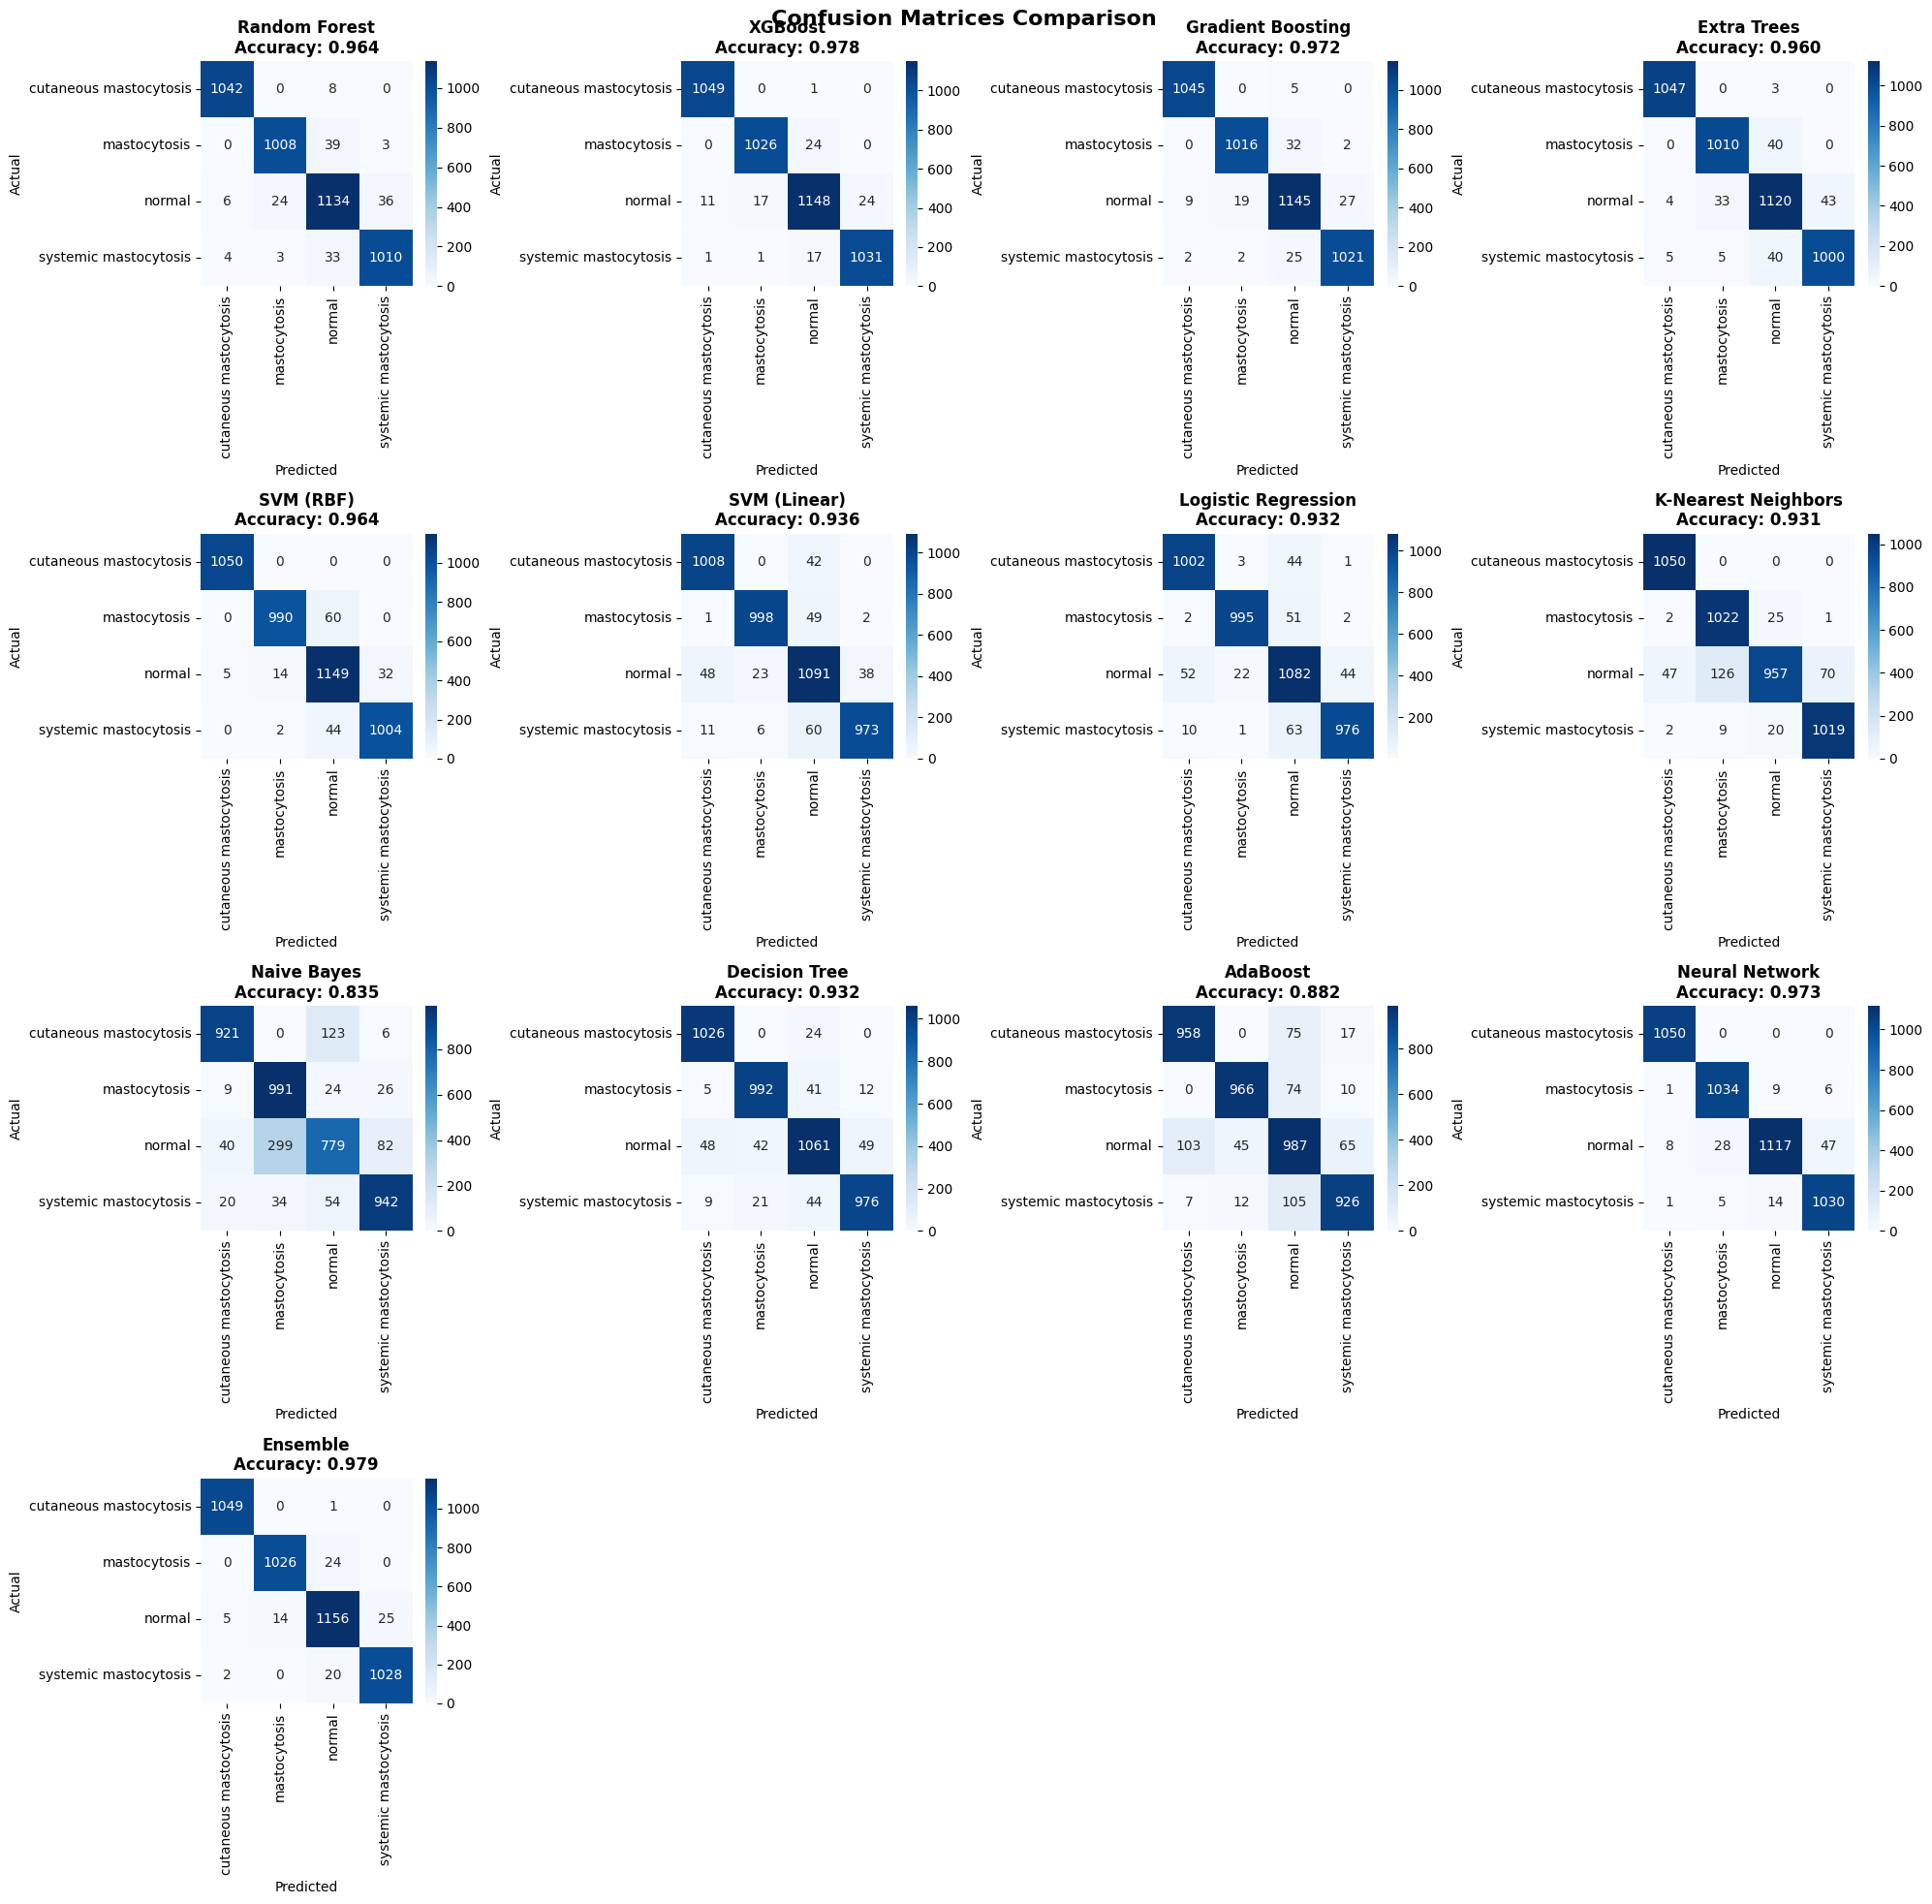

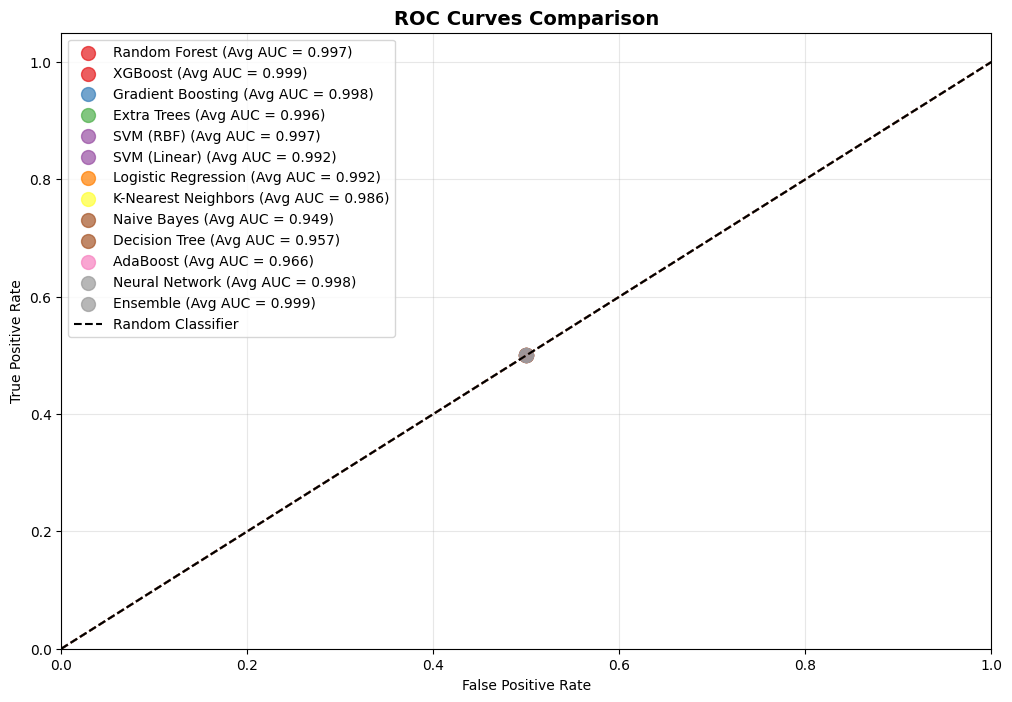

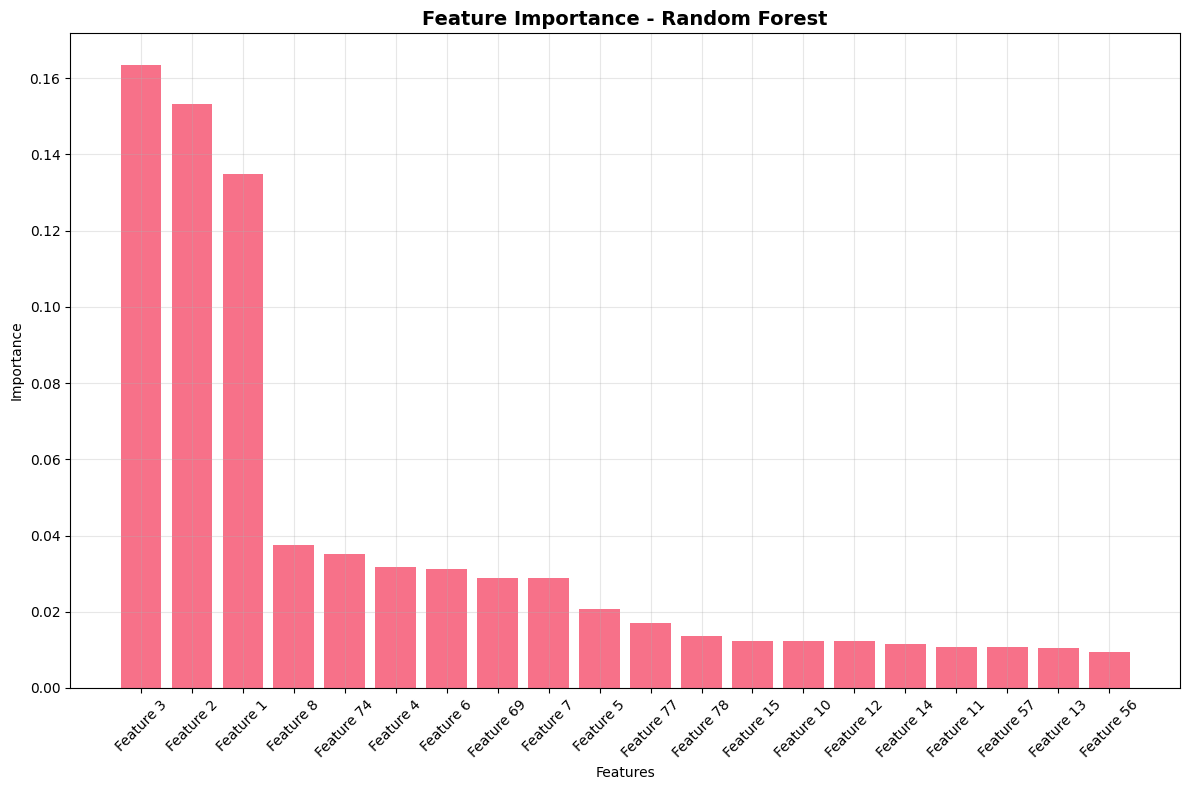

Results saved to 'ml_comparison_results.json'
Best Model: Ensemble with 97.91% accuracy
Fastest Model: K-Nearest Neighbors


In [29]:
ml_comparison, visualizer, results = run_ml_pipeline(file_path)

In [30]:
pipeline_info = {
    'dataset_shape': data.shape,
    'n_classes': num_classes,
    'class_names': label_encoder.classes_.tolist(),
    'final_accuracy': float(test_accuracy),
    'feature_dimensions': X_selected.shape[1],
    'balanced_samples': X_balanced.shape[0]
}

with open('pipeline_results.json', 'w') as f:
    json.dump(pipeline_info, f, indent=2)